# Домашняя работа: "Методы оптимизации"

ФИО: **Дарханов Евгений Владленович**

## Описание задания:
Вам необходимо реализовать оставшиеся методы оптимизации, которые разбирались на лекции: <b>Momentum, AdaDelta, Adam</b>. Сравнение методов оптимизации нужно провести на примере из семинара, а также при обучении сверточной нейронной сети на датасете MNIST.



## Задание разделено на следующие части:
1.1 Реализация методов Momentum, AdaDelta, Adam **(1 балл)**

1.2 Сравнение реализованных методов **(1 балл)**

2.1 Реализация сверточной нейронной сети и обучение ее на MNIST **(2 балла)**

2.2 Сравнение графиков обучения для нейросети на реализованных методах **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 17 декабря.

In [1]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

## Часть 1: Реализация методов

In [2]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

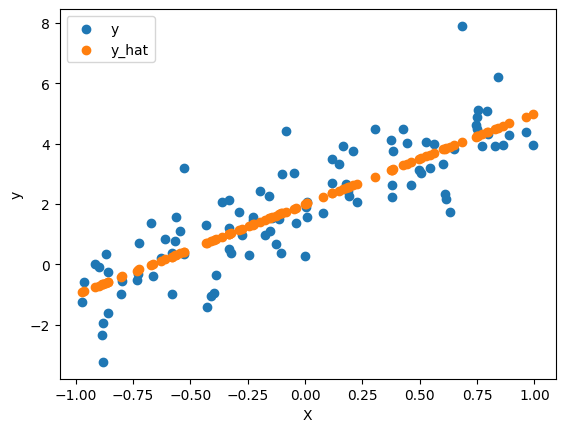

In [3]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

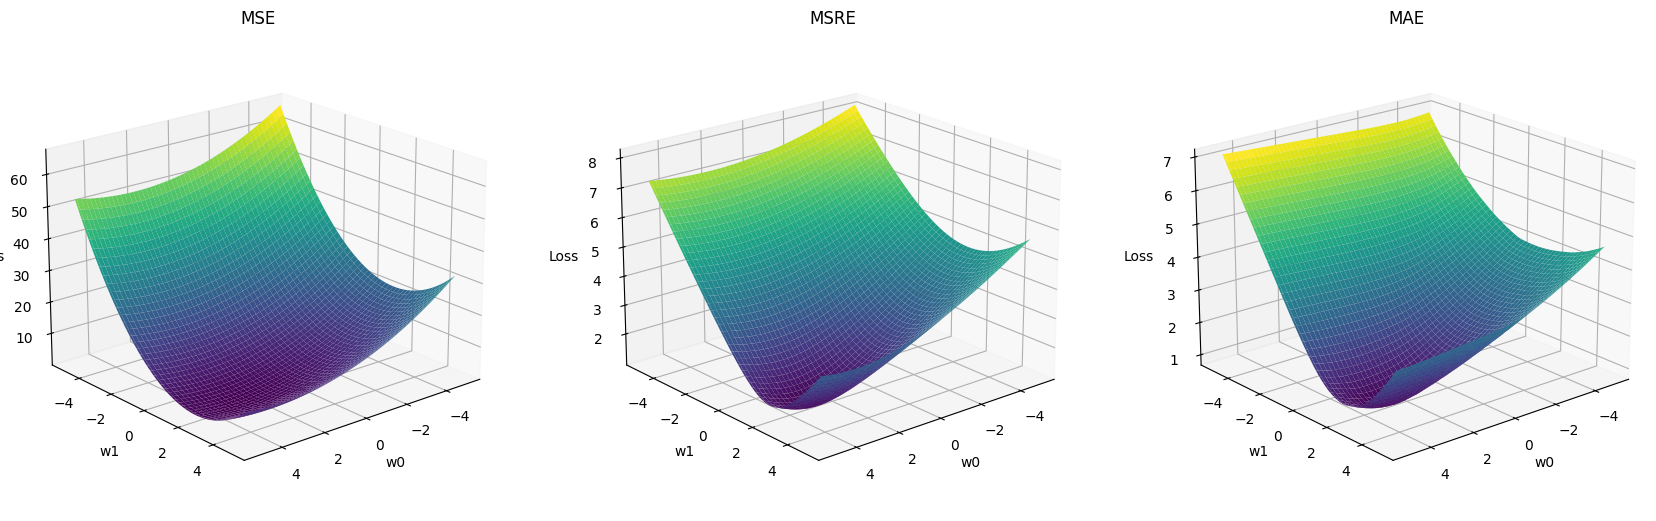

In [4]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

In [5]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()

In [6]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses

In [7]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in optim_list:
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

Реализация методов SGD и AdaGrad с семинара:

In [8]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad

In [9]:
class AdaGrad(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2):
        super().__init__(params)
        self.epsilon = epsilon
        self.eta = eta

        self.G = [0] * len(self.params)

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.G[i] += p.grad ** 2

                p -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * p.grad

### 1.1 Реализуйте методы Momentum, AdaDelta, Adam. **(1 балл)**

#### Momentum
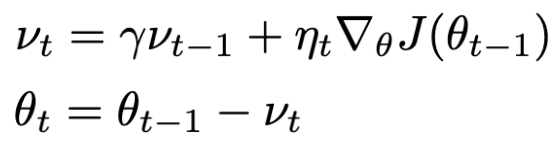

In [10]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma
        self.momentum = [torch.zeros(param.shape) for param in self.params]

    def step(self):
        with torch.no_grad():
            for i, param in enumerate(self.params):
                if param.grad is not None:
                    prev_momentum = self.momentum[i]
                    self.momentum[i] = self.gamma * prev_momentum + self.lr * param.grad
                    param -= self.momentum[i]

#### AdaDelta
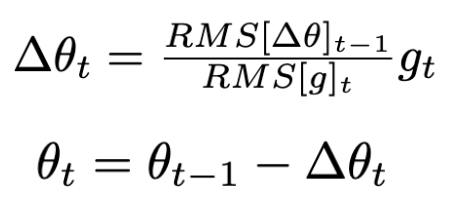

In [16]:
class AdaDelta(Optimizer):
    def __init__(self, params, epsilon=1e-8, gamma=0.9):
        super().__init__(params)
        self.epsilon = epsilon
        self.gamma = gamma

        self.G = [torch.zeros(param.shape) for param in self.params]
        self.theta = [torch.zeros(param.shape) for param in self.params]

    def step(self):
        with torch.no_grad():
            for i, param in enumerate(self.params):
                if param.grad is not None:
                    self.G[i] = self.gamma * self.G[i] + (1 - self.gamma) * (param.grad ** 2)
                    rms_g = torch.sqrt(self.G[i] + self.epsilon)

                    self.theta[i] = self.gamma * self.theta[i] + (1 - self.gamma) * (self.theta[i] ** 2)
                    rms_theta = torch.sqrt(self.theta[i] + self.epsilon)

                    param -= (rms_theta / rms_g) * param.grad

#### Adam
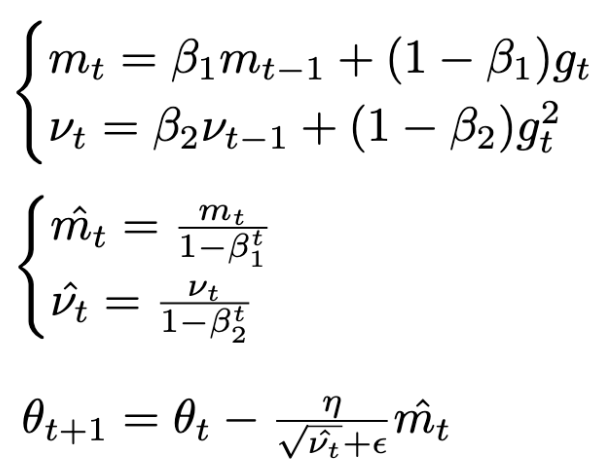

In [17]:
class Adam(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2, beta_1=0.9, beta_2=0.999):
        super().__init__(params)
        self.epsilon = epsilon
        self.eta = eta
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.iter = 1
        self.G = [torch.zeros(param.shape) for param in self.params]
        self.m = [torch.zeros(param.shape) for param in self.params]

    def step(self):
        with torch.no_grad():
            for i, param in enumerate(self.params):
                if param.grad is not None:
                    self.m[i] = self.beta_1 * self.m[i] + (1 - self.beta_1) * param.grad
                    self.G[i] = self.beta_2 * self.G[i] + (1 - self.beta_2) * (param.grad ** 2)

                    m_hat = self.m[i] / (1 - self.beta_1 ** self.iter)
                    g_hat = self.G[i] / (1 - self.beta_2 ** self.iter)

                    param -= (self.eta / torch.sqrt(g_hat + self.epsilon)) * m_hat

        self.iter += 1

### 1.2 Сравните реализованные методы на предложенном примере **(1 балл)**

In [19]:
from functools import partial

points, losses = optimize_function(partial(loss_animator.loss_func, loss=mse), AdaDelta, {'epsilon': 1e-8}, start_point=[-4, -4], num_iter=100)

In [21]:
compare_optimizers(
    loss_animator,
    mse,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        ['Momentum', Momentum, {'lr': 1e-2, 'gamma': 0.9}],
        ['AdaGrad', AdaGrad, {'epsilon': 1e-8, 'eta': 1}],
        ['AdaDelta', AdaDelta, {'epsilon': 1e-8, 'gamma': 0.9}],
        ['Adam', Adam, {'epsilon': 1e-8, 'eta': 1, 'beta_1': 0.9, 'beta_2': 0.999}],
     ],
    start_point=[-4, -4],
    num_iter=100
)

**AdaDelta двигается очень медленно. Скорее всего, это связано с инициализацией нулями**

##  Часть 2: Обучение нейронной сети

### 2.1 Реализуйте сверточную нейронную сеть и обучите ее на MNIST с помощью методов Adam, Adagrad, AdaDelta и SGD. Для обучения используйте оптимизаторы из первой части, а не из pytorch. **(2 балла)**

Скачайте датасет и реализуйте даталоудеры:

In [27]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

--2024-12-14 15:07:03--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2024-12-14 15:07:04--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz’

MNIST.tar.gz            [             <=>    ]  33.20M  11.8MB/s    in 2.8s    

2024-12-14 15:07:07 (11.8 MB/s) - ‘MNIST.tar.gz’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw/tra

In [28]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

Реализуйте сверточную нейронную нейронную сеть по шаблону:

* Используйте сверточные (nn.Conv2d) и полносвязные (nn.Linear) слои
* Не забудьте преобразовать тензор перед подачей в полносвязный слой (x = x.view(-1, d1), где d1 -- размерность входа первого полносвязного слоя)
* Можно использовать dropout (nn.Dropout2d) и функции активации (например, F.relu)
* В конце метода forward необходимо использовать F.log_softmax для предсказания класса изображения

In [36]:
import torch.nn as nn
import torch.nn.functional as F


class MNISTNet(nn.Module):
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.dropout = nn.Dropout()
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=5*5*16, out_features=120),
            nn.ReLU()
        )
        self.fc2 = nn.Linear(in_features=120, out_features=10)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.fc2(x)
        return F.log_softmax(x)

Запустите обучение, постройте график лоссов от эпохи:

In [37]:
def train(model, optimizer, n_epochs, train_loader, val_loader, device):
    model = model.to(device)

    # храним по эпохам
    train_accuracies, train_losses = [], []
    val_accuracies, val_losses = [], []

    for epoch in range(n_epochs):
        model.train()
        train_loss, train_accuracy = [], []

        for x_train, y_train in tqdm(train_loader):
            x_train = x_train.to(device)
            y_train = y_train.to(device)

            y_pred = model.forward(x_train)

            # loss = F.cross_entropy(y_pred, y_train)
            loss = F.nll_loss(y_pred, y_train)

            train_loss.append(loss.item())
            train_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_train).cpu().numpy().tolist())

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        train_accuracies.append(np.mean(train_accuracy))
        train_losses.append(np.mean(train_loss))

        # валидация
        model.eval()
        val_loss, val_accuracy = [], []
        with torch.no_grad():
            for x_val, y_val in tqdm(test_loader):
                x_val = x_val.to(device)
                y_val = y_val.to(device)

                y_pred = model.forward(x_val).to(device)

                loss = F.cross_entropy(y_pred, y_val)
                val_loss.append(loss.item())
                val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).cpu().numpy().tolist())

        val_accuracies.append(np.mean(val_accuracy))
        val_losses.append(np.mean(val_loss))

        print(f'Epoch: {epoch}, train loss: {np.mean(train_loss)}, accuracy: {np.mean(train_accuracy)}')
        print(f'Epoch: {epoch}, val loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')

    return {'train_losses': train_losses, 'train_accuracies': train_accuracies,
            'val_losses': val_losses, 'val_accuracies': val_accuracies}

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 10

In [42]:
history = {}


for optim_name, (optim, args) in {
    'Adam': (Adam, {'epsilon': 1e-8, 'eta': 1e-2}),
    'AdaGrad' : (AdaGrad, {'epsilon': 1e-8, 'eta': 1}),
    'AdaDelta': (AdaDelta, {'epsilon': 1e-8, 'gamma': 0.9}),
    'SGD': (SGD, {'lr': 1e-1})
    }.items():

    model = MNISTNet()
    optimizer = optim(model.parameters(), **args)

    result = train(model, optimizer, epochs, train_loader, test_loader, device)
    history[optim_name] = result

  0%|          | 0/1875 [00:00<?, ?it/s]

<ipython-input-36-dadbb8b12f6f>:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 0, train loss: 0.33412261174743374, accuracy: 0.898
Epoch: 0, val loss: 0.09823406042424015, accuracy: 0.9711


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1, train loss: 0.2606037874524792, accuracy: 0.9269
Epoch: 1, val loss: 0.10868908092305184, accuracy: 0.9662


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2, train loss: 0.250868732829392, accuracy: 0.9311
Epoch: 2, val loss: 0.10200009022812588, accuracy: 0.9688


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3, train loss: 0.25097478229620807, accuracy: 0.9334
Epoch: 3, val loss: 0.12064321725030457, accuracy: 0.9647


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4, train loss: 0.24197845013346522, accuracy: 0.9363666666666667
Epoch: 4, val loss: 0.11185178076535963, accuracy: 0.9675


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5, train loss: 0.23734781659642856, accuracy: 0.93955
Epoch: 5, val loss: 0.10703920143635605, accuracy: 0.9708


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 6, train loss: 0.24074704065984115, accuracy: 0.9389
Epoch: 6, val loss: 0.09480756912034559, accuracy: 0.9752


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 7, train loss: 0.22561169086440155, accuracy: 0.9435333333333333
Epoch: 7, val loss: 0.12212360856277993, accuracy: 0.9678


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 8, train loss: 0.2350591249938123, accuracy: 0.9424
Epoch: 8, val loss: 0.11816935080993242, accuracy: 0.9682


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 9, train loss: 0.23060672019738704, accuracy: 0.9435166666666667
Epoch: 9, val loss: 0.12298950116606072, accuracy: 0.9653


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 0, train loss: 784.9361326114655, accuracy: 0.10303333333333334
Epoch: 0, val loss: 2.3046569588085335, accuracy: 0.1135


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1, train loss: 2.3047609700520835, accuracy: 0.10648333333333333
Epoch: 1, val loss: 2.30245070107067, accuracy: 0.1135


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2, train loss: 2.3040843002319336, accuracy: 0.1078
Epoch: 2, val loss: 2.3045840636609842, accuracy: 0.101


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3, train loss: 2.303512744394938, accuracy: 0.10845
Epoch: 3, val loss: 2.3024978508202794, accuracy: 0.1135


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4, train loss: 2.303435770289103, accuracy: 0.10863333333333333
Epoch: 4, val loss: 2.303693943511183, accuracy: 0.1135


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5, train loss: 2.302958188247681, accuracy: 0.10895
Epoch: 5, val loss: 2.30183149221987, accuracy: 0.1135


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 6, train loss: 2.302879573186239, accuracy: 0.10835
Epoch: 6, val loss: 2.3017571231427665, accuracy: 0.1135


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 7, train loss: 2.3029092742919923, accuracy: 0.1089
Epoch: 7, val loss: 2.3045611709070664, accuracy: 0.1028


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 8, train loss: 2.3026713291168215, accuracy: 0.1092
Epoch: 8, val loss: 2.3037857255234884, accuracy: 0.101


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 9, train loss: 2.302775515619914, accuracy: 0.10906666666666667
Epoch: 9, val loss: 2.3021408269961423, accuracy: 0.1135


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 0, train loss: 0.7181901773373286, accuracy: 0.7858833333333334
Epoch: 0, val loss: 0.22840772027643724, accuracy: 0.936


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1, train loss: 0.26282203091681006, accuracy: 0.9206666666666666
Epoch: 1, val loss: 0.13541872203409577, accuracy: 0.9604


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2, train loss: 0.19050356860657533, accuracy: 0.9428166666666666
Epoch: 2, val loss: 0.10098851011164439, accuracy: 0.9692


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3, train loss: 0.15688565185169379, accuracy: 0.95185
Epoch: 3, val loss: 0.08765480473649483, accuracy: 0.9726


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4, train loss: 0.1410193160548806, accuracy: 0.9576833333333333
Epoch: 4, val loss: 0.07484771726733318, accuracy: 0.9765


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5, train loss: 0.12911683055199683, accuracy: 0.9608
Epoch: 5, val loss: 0.0699719163107897, accuracy: 0.9784


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 6, train loss: 0.1187121669922024, accuracy: 0.96365
Epoch: 6, val loss: 0.06383338492451468, accuracy: 0.9803


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 7, train loss: 0.11202463434338569, accuracy: 0.9658833333333333
Epoch: 7, val loss: 0.06048924941011666, accuracy: 0.9816


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 8, train loss: 0.10739207439552993, accuracy: 0.9677166666666667
Epoch: 8, val loss: 0.05656435767995021, accuracy: 0.9811


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 9, train loss: 0.09961653430908918, accuracy: 0.9697833333333333
Epoch: 9, val loss: 0.0542309447809066, accuracy: 0.9826


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 0, train loss: 0.25215298002449177, accuracy: 0.91955
Epoch: 0, val loss: 0.05453773872638954, accuracy: 0.9813


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 1, train loss: 0.11232756299047421, accuracy: 0.96535
Epoch: 1, val loss: 0.04508143889542205, accuracy: 0.9853


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 2, train loss: 0.09458916535793493, accuracy: 0.9706166666666667
Epoch: 2, val loss: 0.036873329561739304, accuracy: 0.9866


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 3, train loss: 0.08432407858160634, accuracy: 0.9737666666666667
Epoch: 3, val loss: 0.03717119638465335, accuracy: 0.9875


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 4, train loss: 0.07480662108554194, accuracy: 0.97685
Epoch: 4, val loss: 0.03412584005399405, accuracy: 0.9904


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 5, train loss: 0.07145668491407609, accuracy: 0.97695
Epoch: 5, val loss: 0.040339429600211904, accuracy: 0.9871


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 6, train loss: 0.06604105612142011, accuracy: 0.9796166666666667
Epoch: 6, val loss: 0.0262226367083091, accuracy: 0.992


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 7, train loss: 0.06444894877196444, accuracy: 0.97945
Epoch: 7, val loss: 0.02787382831934991, accuracy: 0.9908


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 8, train loss: 0.06215387536196504, accuracy: 0.9803
Epoch: 8, val loss: 0.029178301367407813, accuracy: 0.9907


  0%|          | 0/1875 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

Epoch: 9, train loss: 0.0580621635060835, accuracy: 0.9821833333333333
Epoch: 9, val loss: 0.030390336399311393, accuracy: 0.991


In [43]:
history['Adam']

{'train_losses': [0.33412261174743374,
  0.2606037874524792,
  0.250868732829392,
  0.25097478229620807,
  0.24197845013346522,
  0.23734781659642856,
  0.24074704065984115,
  0.22561169086440155,
  0.2350591249938123,
  0.23060672019738704],
 'train_accuracies': [0.898,
  0.9269,
  0.9311,
  0.9334,
  0.9363666666666667,
  0.93955,
  0.9389,
  0.9435333333333333,
  0.9424,
  0.9435166666666667],
 'val_losses': [0.09823406042424015,
  0.10868908092305184,
  0.10200009022812588,
  0.12064321725030457,
  0.11185178076535963,
  0.10703920143635605,
  0.09480756912034559,
  0.12212360856277993,
  0.11816935080993242,
  0.12298950116606072],
 'val_accuracies': [0.9711,
  0.9662,
  0.9688,
  0.9647,
  0.9675,
  0.9708,
  0.9752,
  0.9678,
  0.9682,
  0.9653]}

### 2.2 Сравните графики обучения для нейросети на методах Adam, Adagrad, AdaDelta и SGD. **(1 балл)**

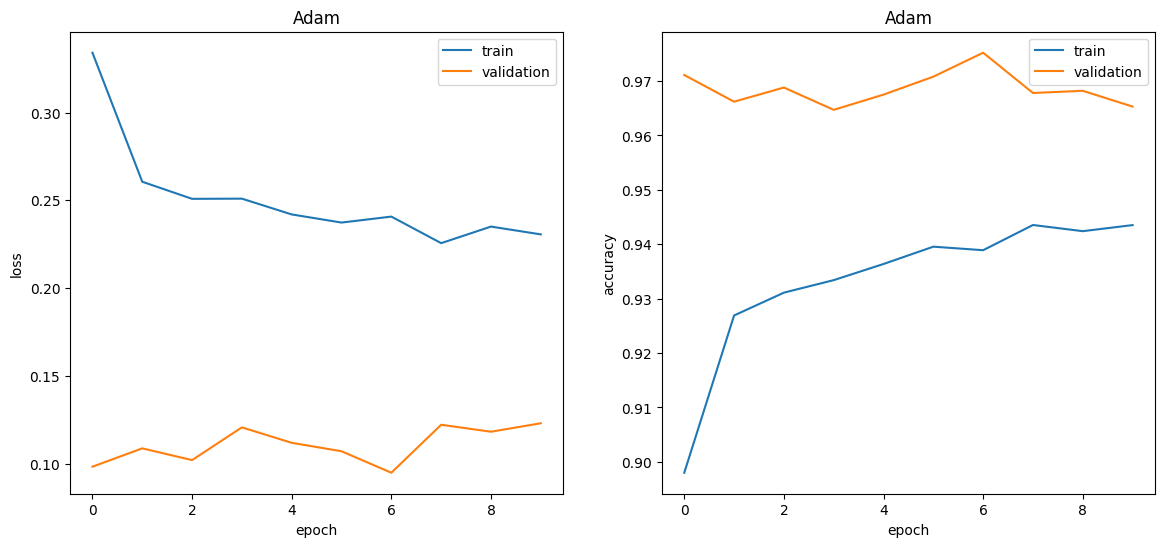

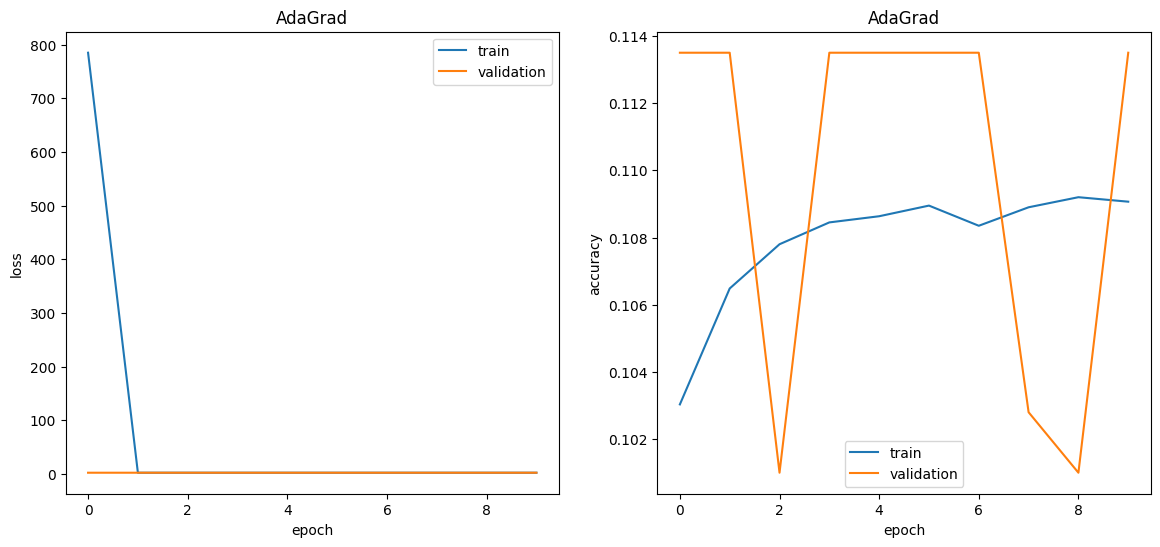

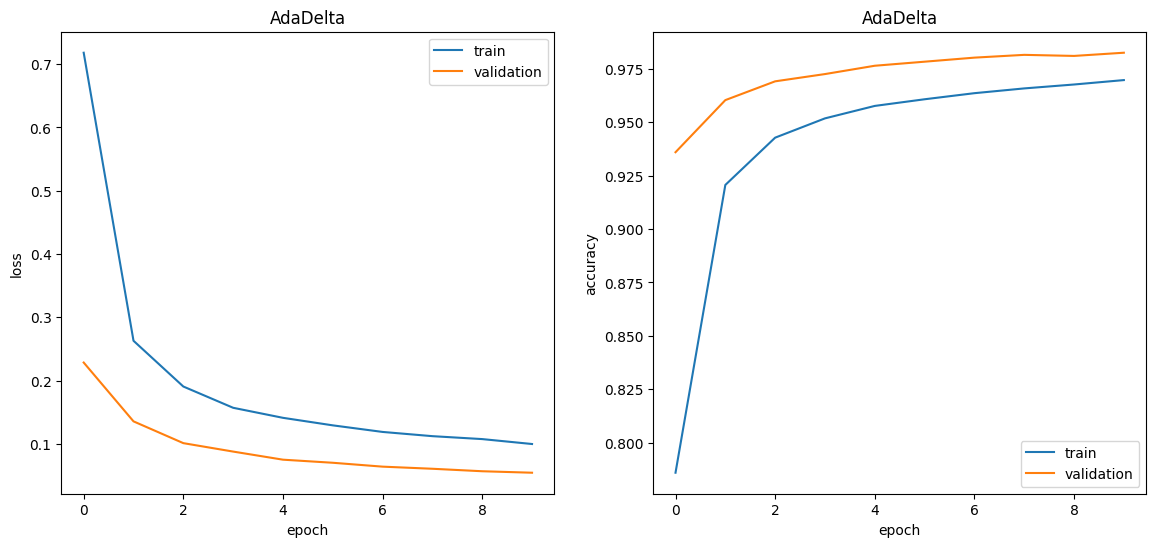

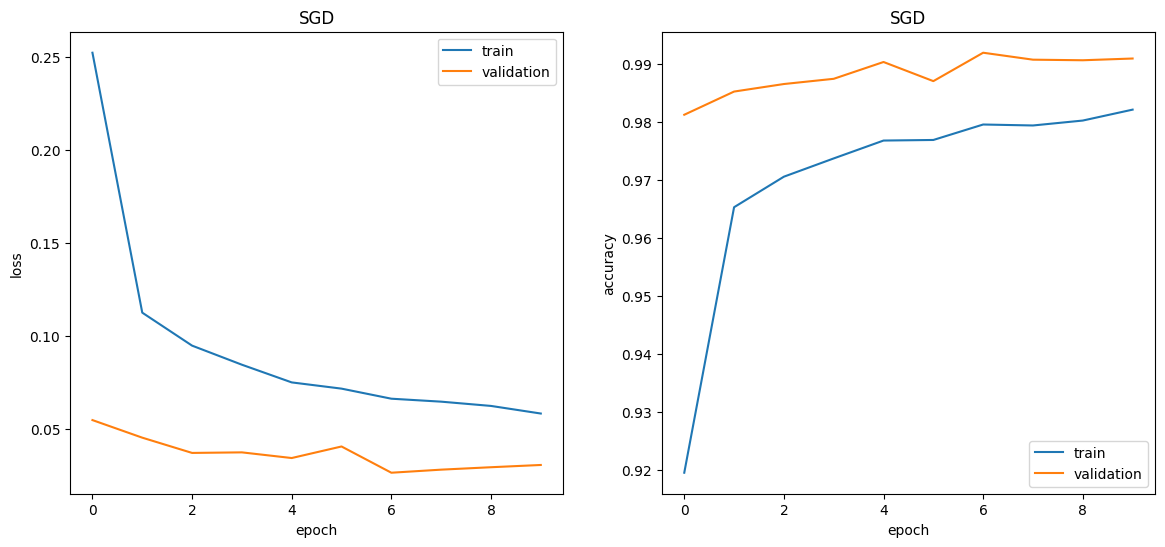

In [45]:
for name, result in history.items():

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    axs[0].plot(result['train_losses'], label='train')
    axs[0].plot(result['val_losses'], label='validation')
    axs[0].set_ylabel('loss')

    axs[1].plot(result['train_accuracies'], label='train')
    axs[1].plot(result['val_accuracies'], label='validation')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_title(name)
        ax.set_xlabel('epoch')
        ax.legend()

- у всех, кроме **AdaGrad**, близкие и хорошие результаты
- лучшее качество показывает **SGD**
- **AdaDelta** показывает наиболее плавное и стабильное обучение, пусть и с большего значения ошибки
- **Adam** словно сразу обучился. Accuracy на валидации не растёт, а колеблется

В целом все эти результаты зависят от параметров, передаваемых в сами оптимизаторы, поэтому для более правильной картины их следует подбирать